# Dimensionality Reduction for Predictive Modeling

A key feature that has allowed neural networks to solve complex problems on data with many features is their ability to construct lower-dimensional representations of features that retain a high degree of meaningful information. In other words, they can encode the higher-dimensional representations into lower-dimensional representations. However, constructing such low-dimensional representations is the primary objective of dimensionality reduction techniques, a class of unsupervised machine learning algorithms. 

## Data

In this notebook, we will explore the possibility of using dimensionality reduction (DR) techniques to solve a predictive modeling problem that is frequently used as an introduction to computer vision. Specifically, we will explore the utility of using dimensionality reduction techniques to correctly predict handwritten digits from the MNIST dataset. From https://en.wikipedia.org/wiki/MNIST_database:
> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.
>
> The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support-vector machine to get an error rate of 0.8%

Although the dimensionality reduction exercise we will explore differs from the encoders we see with neural networks, the core concept of reducing dimension while retaining information is the same. The following code block imports the libraries we will use.

In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import polars as pl
import pacmap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.model_selection import train_test_split

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The following code block reads both the feature data (`feature_data`) and the labels (`target_data`).



In [2]:
feature_data = pl.read_parquet('data/mnist_features.parquet')
target_data = pl.read_parquet(
    'data/mnist_target.parquet'
).rename({
    'class': 'label'
}).with_columns(
    pl.col('label').cast(pl.Int64)
)

The following code block prints the shape of our `DataFrame` objects. Note that we have 70,000 observations.

In [3]:
print(f' - {feature_data.shape = }')
print(f' - {target_data.shape = }')

 - feature_data.shape = (70000, 784)
 - target_data.shape = (70000, 1)


As the previous cell shows, the feature data has 784 columns. Recall from the earlier description that the MNIST dataset includes images of size 28 pixels x 28 pixels. The total number of pixels is 784 (28 x 28), so each row represents a flattened vector of the pixels for a single image. The following code block defines a function to plot the image for a single row.

In [4]:
def plot_digit(index=0):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(
        feature_data[index].to_numpy().reshape(28, 28),
        cmap='binary',
        cbar=False,
    )
    ax.set_title(f'Actual: {target_data[index].item()}')

    plt.show()

The following code block runs an interactive widget that allows you to view a sample of digits.

In [5]:
interact(plot_digit, index=range(20));

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

The following code block creates training and testing datasets.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_data, 
    target_data, 
    test_size=0.10, 
    random_state=42,
    stratify=target_data,
)

## Technique 1: Principal Components Analysis (PCA)

We will first look at how Principal Components Analysis (PCA) fares for the dimensionality reduction task. PCA assumes that:
- relationships between features are linear,
- components with the highest variance are the most important, and
- data is centered around the mean.


The following code block: 
- imports the PCA class from `scikit-learn`,
- imports a `StandardScaler` from `scikit-learn`,
- fits a `StandardScaler` instance to the training data,
- defines a `pca` object that seeks to identify two principal components in data,
- fits the PCA model on the scaled training set, and
- prints the explained variance, which is rather low.

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
pca = PCA(n_components=2)
pca.fit(scaler.transform(X_train))

sum(pca.explained_variance_ratio_)

0.09676523272548002

The following code block uses the fitted PCA model to generate the reduced dimension embeddings for the training and testing datasets. 

In [8]:
pca_emb_train = pca.transform(scaler.transform(X_train))
pca_emb_test = pca.transform(scaler.transform(X_test))

Before we do any predictive modeling, let's visualize the PCA embeddings. This is done in the following code block, which first creates a `polars DataFrame` with the embeddings and then generates a scatterplot using different colors for each label. The key thing to note is that class separation is rather indistinct.

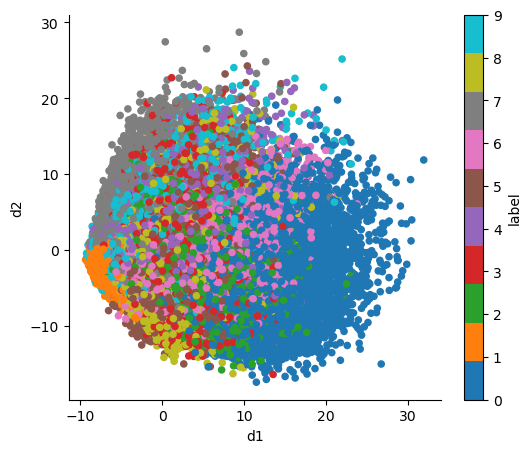

In [9]:
pca_emb_df = pl.DataFrame(
    pca_emb_train,
    schema=['d1', 'd2'],
).with_columns(
    pl.Series(name='label', values=y_train.get_column('label').to_numpy())
)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

pca_emb_df.to_pandas().plot(
    kind='scatter',
    x='d1',
    y='d2',
    c='label',
    alpha=1.0,
    cmap='tab10',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

The following code block uses the PCA embeddings as input to a multi-class Random Forest model that seeks to use the features to predict the appropriate class. The classifier's accuracy on the training and testing datasets is printed.

In [10]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    n_jobs=6,
)

clf.fit(
    X=pca_emb_train, 
    y=y_train.to_numpy().ravel()
)

train_accuracy = (
    clf.predict(pca_emb_train) == y_train.to_numpy().ravel()
).sum()/len(pca_emb_train)

test_accuracy = (
    clf.predict(pca_emb_test) == y_test.to_numpy().ravel()
).sum()/len(pca_emb_test)

print(f' - {train_accuracy = :.3%}')
print(f' - {test_accuracy = :.3%}')

 - train_accuracy = 42.046%
 - test_accuracy = 37.757%


The following code block creates a `polars DataFrame` that includes the predictions and actual labels for instances in the test data.

In [11]:
pca_predictions_df = pl.DataFrame().with_columns(
    pl.Series(name='actual', values=y_test),
    pl.Series(name='predicted', values=clf.predict(pca_emb_test))
).with_columns(
    correct = pl.when(
        pl.col('actual') == pl.col('predicted')
    ).then(1).otherwise(0)
)

The following code block shows the correct classifications by digit.

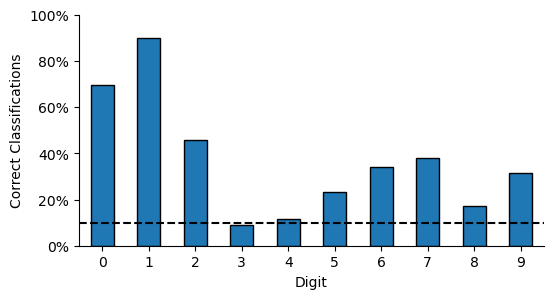

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

pca_predictions_df.group_by(
    'actual'
).agg(
    pl.col('correct').mean()
).sort(
    'actual'
).to_pandas().plot(
    kind='bar',
    x='actual',
    y='correct',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.tick_params(
    axis='x',
    rotation=0,
)
ax.axhline(
    y=0.1, 
    color='k', 
    linestyle='--',
)
ax.set_xlabel('Digit')
ax.set_ylabel('Correct Classifications')
ax.set_ylim(0, 1)
ax.spines[['right', 'top']].set_visible(False)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

plt.show()

The following code block uses a heatmap to help understand the type of misclassifications that are being made.

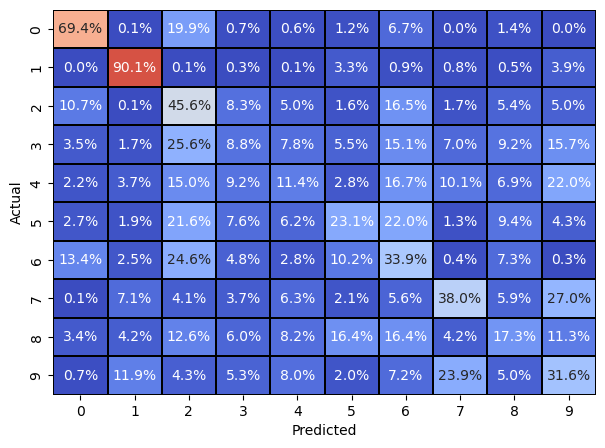

In [13]:
misclassifications_df = pca_predictions_df.pivot(
    index='actual',
    on='predicted',
    values='correct',
    aggregate_function='len'
).fill_null(0).to_pandas().set_index(
    'actual'
).sort_index().sort_index(
    axis=1
)
misclassifications_df = misclassifications_df.divide(
    misclassifications_df.sum(axis=1),
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.heatmap(
    misclassifications_df,
    cmap='coolwarm',
    vmax=1.0,
    vmin=0.0,
    linewidths=0.1,
    linecolor='k',
    cbar=False,
    annot=True,
    fmt='.1%'
)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.show()

The previous results show that while PCA allows relatively high classification accuracy for some classes (e.g., 0 and 1), it does not consistently yield high performance. 

#### DR Technique 2: Pairwise Controlled Manifold Approximation (PaCMAP)

We will now look at PaCMAP (see https://github.com/YingfanWang/PaCMAP). In contrast to PCA, PaCMAP is a nonlinear dimensionality technique designed to preserve both the global and local structure among data points. The following code block fits a *default* version of the method and uses it to create training and testing sets of embedded values. **Note** we do not need to scale the data before using PaCMAP, but we do need to provide a `basis` argument when transforming the test dataset.

In [14]:
reducer = pacmap.PaCMAP(random_state=42)

pacmap_emb_train = reducer.fit_transform(X_train)
pacmap_emb_test = reducer.transform(
    X=X_test, 
    basis=X_train,
)

/home/nick/miniconda3/envs/primary/lib/python3.12/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


The following code block visualizes the PaCMAP embeddings. As you can see, the embeddings separate the classes much more distinctly than we observed with PCA.

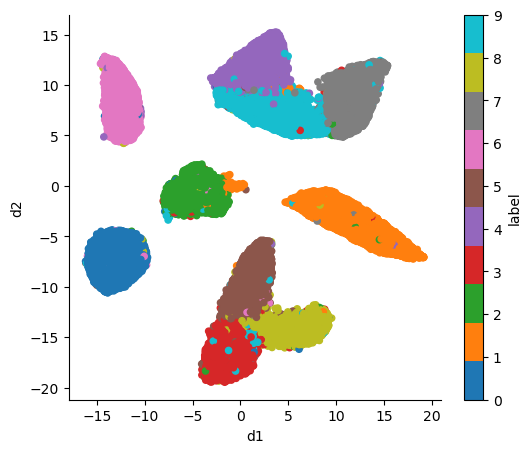

In [15]:
pacmap_emb_df = pl.DataFrame(
    pacmap_emb_train,
    schema=['d1', 'd2'],
).with_columns(
    pl.Series(name='label', values=y_train.get_column('label').to_numpy())
)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

pacmap_emb_df.to_pandas().plot(
    kind='scatter',
    x='d1',
    y='d2',
    c='label',
    alpha=1.0,
    cmap='tab10',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

The following code block uses the PaCMAP embeddings as input to a multi-class Random Forest model that seeks to use the features to predict the appropriate class. The classifier's accuracy on the training and testing datasets is printed.

In [16]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    n_jobs=6,
)

clf.fit(
    X=pacmap_emb_train, 
    y=y_train.to_numpy().ravel()
)

train_accuracy = (
    clf.predict(pacmap_emb_train) == y_train.to_numpy().ravel()
).sum()/len(pacmap_emb_train)

test_accuracy = (
    clf.predict(pacmap_emb_test) == y_test.to_numpy().ravel()
).sum()/len(pacmap_emb_test)

print(f' - {train_accuracy = :.3%}')
print(f' - {test_accuracy = :.3%}')

 - train_accuracy = 97.643%
 - test_accuracy = 95.586%


The following code block creates a `polars DataFrame` that includes the predictions and actual labels for instances in the test data.

In [17]:
pacmap_predictions_df = pl.DataFrame().with_columns(
    pl.Series(name='actual', values=y_test),
    pl.Series(name='predicted', values=clf.predict(pacmap_emb_test))
).with_columns(
    correct = pl.when(
        pl.col('actual') == pl.col('predicted')
    ).then(1).otherwise(0)
)

The following code block shows the correct classifications by digit.

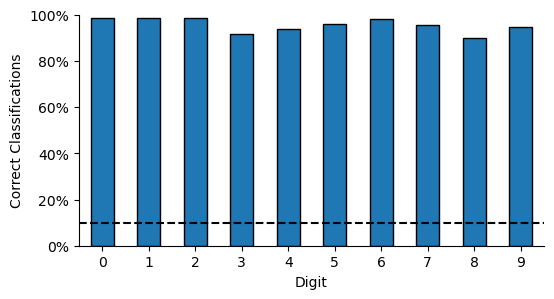

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

pacmap_predictions_df.group_by(
    'actual'
).agg(
    pl.col('correct').mean()
).sort(
    'actual'
).to_pandas().plot(
    kind='bar',
    x='actual',
    y='correct',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.tick_params(
    axis='x',
    rotation=0,
)
ax.axhline(
    y=0.1, 
    color='k', 
    linestyle='--',
)
ax.set_xlabel('Digit')
ax.set_ylabel('Correct Classifications')
ax.set_ylim(0, 1)
ax.spines[['right', 'top']].set_visible(False)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

plt.show()

The following code block uses a heatmap to help understand the type of misclassifications that are being made.

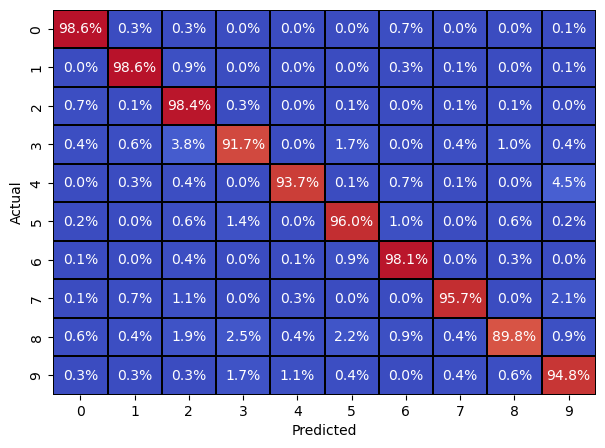

In [19]:
misclassifications_df = pacmap_predictions_df.pivot(
    index='actual',
    on='predicted',
    values='correct',
    aggregate_function='len'
).fill_null(0).to_pandas().set_index(
    'actual'
).sort_index().sort_index(
    axis=1
)
misclassifications_df = misclassifications_df.divide(
    misclassifications_df.sum(axis=1),
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.heatmap(
    misclassifications_df,
    cmap='coolwarm',
    vmax=1.0,
    vmin=0.0,
    linewidths=0.1,
    linecolor='k',
    cbar=False,
    annot=True,
    fmt='.1%'
)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.show()

The results show that PaCMAP's ability to capture nonlinearity in data and preserve local and global structure allows it to perform well on the multi-class classification task. The results we observe are on par, if not better, than those we could achieve with a simple feedforward neural network. The key takeaway is that a high-quality approach to reducing data dimensionality while preserving important information enables high-performing predictive algorithms.